# 4.7.9 XGBoost 모델

In [ ]:
# 아래 두 줄 코딩 즉 xgboost와 lightgbm 설치 구문 중 하나라도 주피터 노트북에서 설치에러 발생시에는
# 구글 코랩에서 이 ipynb 파일을 열고 실행할 것을 추천함

In [ ]:
# 그 때 2017DC1-all.csv 파일을 구글 드라이브에 업로딩하고 이를 구글 코랩에서 불러오기 위해서는 
# 책 본문 4.7.6의 텐서플로 케라스 절의 초반 안내 사항 준수 필요

In [ ]:
pip install xgboost

In [ ]:
pip install lightgbm

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

df = pd.read_csv('2017DC1-all.csv') # 결정 트리 계열 모델에 사용했던 데이터셋인 2017DC1.csv에
                                    # 연속변수 타겟 VALP가 추가된 데이터셋인 2017DC1-all.csv 불러오기
df.shape

(20495, 31)

In [2]:
df.head(3)

,ACCESS,ACR,AGEP,BATH,BDSP,BLD,COW,ELEP,FESRP,FKITP,...,R18,R65,RAC1P,RMSP,RWAT,SCH,SCHL,SEX,VALP,VALP_B1
0,1.0,1.0,74,1.0,3.0,2.0,0,140.0,0,0.0,...,0.0,1.0,1,5.0,1.0,1,21,2,200000.0,1.0
1,1.0,3.0,46,1.0,3.0,2.0,1,280.0,0,0.0,...,0.0,0.0,1,6.0,1.0,1,16,2,850000.0,1.0
2,1.0,3.0,45,1.0,3.0,2.0,1,280.0,0,0.0,...,0.0,0.0,1,6.0,1.0,1,16,1,850000.0,1.0


In [2]:
df.drop(['VALP_B1'], axis=1, inplace=True)   # 이진값 타겟변수 VALP_B1를 제외
df.shape

(20495, 30)

In [4]:
# 참조 코딩
df.head(3)

,ACCESS,ACR,AGEP,BATH,BDSP,BLD,COW,ELEP,FESRP,FKITP,...,NRC,R18,R65,RAC1P,RMSP,RWAT,SCH,SCHL,SEX,VALP
0,1.0,1.0,74,1.0,3.0,2.0,0,140.0,0,0.0,...,0.0,0.0,1.0,1,5.0,1.0,1,21,2,200000.0
1,1.0,3.0,46,1.0,3.0,2.0,1,280.0,0,0.0,...,0.0,0.0,0.0,1,6.0,1.0,1,16,2,850000.0
2,1.0,3.0,45,1.0,3.0,2.0,1,280.0,0,0.0,...,0.0,0.0,0.0,1,6.0,1.0,1,16,1,850000.0


In [3]:
data = df.drop(['VALP'], axis=1)   # 타겟변수(VALP임에 주의)를 제외한 입력변수를 data에 저장
target = df['VALP']                # 타겟변수만 target에 저장

# 50:50 데이터 변환
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split( 
    data, target, test_size=0.5, random_state=42)   # test_size=0.5임에 주의 

In [8]:
# 기본 XGBRegressor 모델
from sklearn.metrics import r2_score

xgb = XGBRegressor(random_state=0)
xgb.fit(X_train, y_train)
pred = xgb.predict(X_test)

print('r2: {0:.5f}'.format(r2_score(y_test, pred)))


r2: 0.53065


In [4]:
# 그리드 서치 실행
from sklearn.model_selection import GridSearchCV

xgb = XGBRegressor()

parameters = {'colsample_bytree': [0.7],
              'learning_rate': [0.05],
              'max_depth': [16],
              'min_child_weight' : [4],
              'n_estimators': [1000],
              'subsample': [0.8, 0.9]
              }

xgb_grid = GridSearchCV(xgb,
                        parameters,
                        scoring = 'r2',
                        cv = 3,
                        n_jobs = -1,
                        verbose=True)
xgb_grid.fit(X_train, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n...
                                    num_parallel_tree=None, predictor=None,
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                 

In [10]:
print('GridSearchCV 최적 파라미터:', xgb_grid.best_params_)

GridSearchCV 최적 파라미터: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 16, 'min_child_weight': 4, 'n_estimators': 1000, 'subsample': 0.9}


In [11]:
model = xgb_grid.best_estimator_
pred = model.predict(X_test)

print('r2: {0:.5f}'.format(r2_score(y_test, pred)))

r2: 0.65092


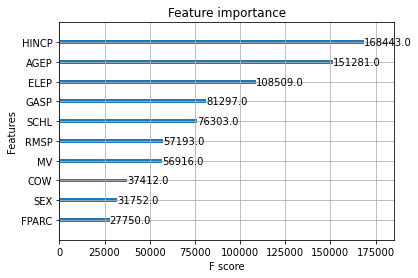

In [12]:
from xgboost import plot_importance

plot_importance(model, max_num_features=10);

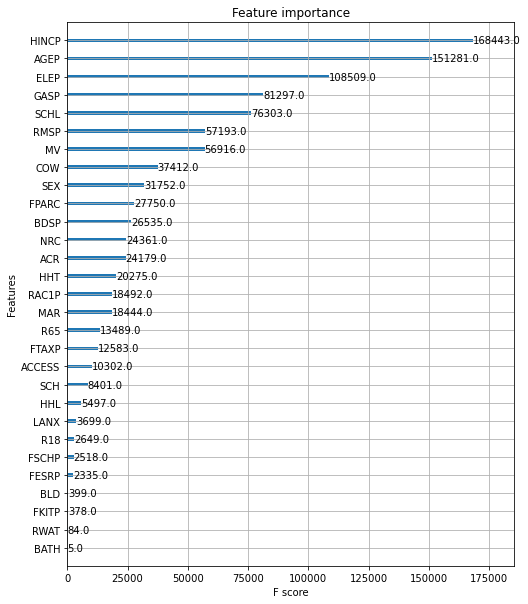

In [13]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(8, 10))
plot_importance(model, ax=ax);

# 4.7.10 LightGBM 모델

In [4]:
# 기본 lGBMRegressor 모델
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score

lgb = LGBMRegressor(random_state=0)
lgb.fit(X_train, y_train)
pred = lgb.predict(X_test)

print('r2: {0:.5f}'.format(r2_score(y_test, pred)))

r2: 0.46083


In [5]:
#그리드 서치 실행
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor

lgb = LGBMRegressor()

parameters = {'colsample_bytree': [0.7, 0.8],
              'learning_rate': [0.1, 0.15, 0.2],
              'max_depth': [11],
              'min_child_weight' : [4],
              'n_estimators': [1000],
              'subsample': [0.3, 0.4]
              }

lgb_grid = GridSearchCV(lgb,
                        parameters,
                        scoring = 'r2',
                        cv = 3,
                        n_jobs = -1,
                        verbose=True)
lgb_grid.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3, estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.8],
                         'learning_rate': [0.1, 0.15, 0.2], 'max_depth': [11],
                         'min_child_weight': [4], 'n_estimators': [1000],
                         'subsample': [0.3, 0.4]},
             scoring='r2', verbose=True)

In [6]:
print('GridSearchCV 최적 파라미터:', lgb_grid.best_params_)

GridSearchCV 최적 파라미터: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 11, 'min_child_weight': 4, 'n_estimators': 1000, 'subsample': 0.3}


In [7]:
from sklearn.metrics import r2_score

model = lgb_grid.best_estimator_
pred = model.predict(X_test)

print('r2: {0:.5f}'.format(r2_score(y_test, pred)))

r2: 0.55647


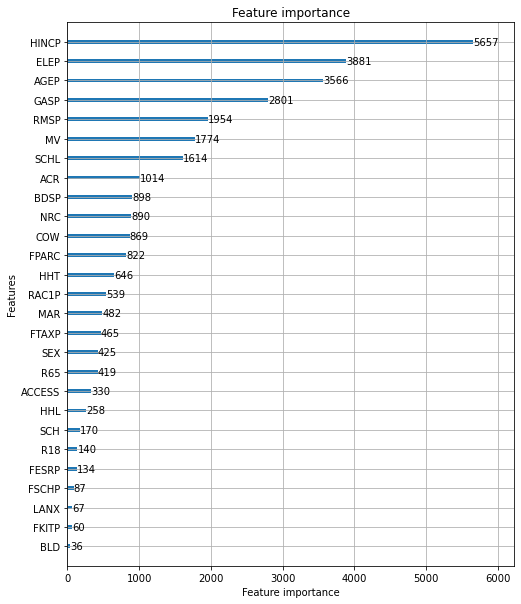

In [8]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(8, 10))
plot_importance(model, ax=ax);

In [6]:
model_xgb = xgb_grid.best_estimator_
pred_xgb = model_xgb.predict(X_test)

model_lgb = lgb_grid.best_estimator_
pred_lgb = model_lgb.predict(X_test)

In [7]:
from sklearn.metrics import r2_score

pred = 0.5*pred_xgb + 0.5*pred_lgb
print('r2: {0:.5f}'.format(r2_score(y_test, pred)))

r2: 0.62143


In [8]:
# 참조 코딩
pred = 0.6*pred_xgb + 0.4*pred_lgb
print('r2: {0:.5f}'.format(r2_score(y_test, pred)))

r2: 0.63016


In [9]:
# 참조 코딩
pred = 0.7*pred_xgb + 0.3*pred_lgb
print('r2: {0:.5f}'.format(r2_score(y_test, pred)))

r2: 0.63748


In [10]:
# 참조 코딩
pred = 0.8*pred_xgb + 0.2*pred_lgb
print('r2: {0:.5f}'.format(r2_score(y_test, pred)))

r2: 0.64338


In [11]:
# 참조 코딩
pred = 0.9*pred_xgb + 0.1*pred_lgb
print('r2: {0:.5f}'.format(r2_score(y_test, pred)))

r2: 0.64786


In [12]:
pred = 0.95*pred_xgb + 0.05*pred_lgb
print('r2: {0:.5f}'.format(r2_score(y_test, pred)))

r2: 0.64957
